## About Data: 
#### Where the data comes from:
- Country Codes with Continent https://gist.github.com/stevewithington/20a69c0b6d2ff846ea5d35e5fc47f26c 
- Minimized Data 1960-2050 https://databank.worldbank.org/reports.aspx?source=Health%20Nutrition%20and%20Population%20Statistics%3A%20Population%20estimates%20and%20projections

Here all countries and times were selected however when considering the series
we removed the % based data of the population for males and females. This is due
to the download limitations of the csv file cells on their website.

## Linear Regression on Continent Population
Steps:
 1. gather continent wise data
 2. format and visualize
 3. split data
 4. fit model
 5. calculate  $r^{2}$ , mean absolute error, root mean squared error



In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import sklearn as sk
import seaborn as sns
import pycountry #country codes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale #data scaling
from sklearn import decomposition #PCA
from sklearn import linear_model #linear model

In [2]:
# load data
def loadData():
    pop_data = pd.read_csv('../Datasets/Population Data 1960-2050.csv', low_memory=False)
    pop_data = pop_data.replace('..', np.nan)
    pop_data = pop_data.iloc[: , 1:] 
    return pop_data

In [3]:
# missing data check
def checkForMissingData(pop_data):
    plt.figure()
    sns.heatmap(pop_data.isnull().transpose(),
                cmap="YlGnBu",
                cbar_kws={'label': 'Missing Data'})
    plt.title("Missing data across dataset")
    plt.show()

In [4]:
# add country code
#list of country codes
def getCountryNonCountryData(pop_data):
    country_codes = []
    country_names = []
    for country in pycountry.countries:
        country_codes.append(country.alpha_3)
        country_names.append(country.name)
    country_codes.sort(key=str.lower)
    country_names.sort(key=str.lower)

    country_data = pop_data[pop_data.Country_Code.isin(country_codes)]
    non_country_data = pop_data[~pop_data.Country_Code.isin(country_codes)]
    non_country_data = non_country_data.iloc[: , 3:] # Removing Continent Codes for non-Nations (Will be NA anyway)
    return country_data, non_country_data

In [5]:
def getTotalPopulation(country_data):
    pop_total = country_data[country_data.Series_Code == "SP.POP.TOTL"] #Population Totals
    return pop_total

In [6]:
#remove unwanted columns
def formatTotalPopulation(pop_total):
    pop_total = pop_total.drop(['Continent_Code','Country_Number','Country_Name','Series_Name','Series_Code'], axis=1)
    pop_total =  pop_total.drop(pop_total.columns[63:],axis=1)
    years = pop_total.columns[2:]
    pop_total[years] = pop_total[years].apply(pd.to_numeric)

    #fix column names - years
    pop_total.columns = pop_total.columns.str.strip("[]")
    return pop_total

In [7]:
# outliers check
# def checkForOutliersInData(pop_total):
#     sns.boxplot(y=pop_total["Continent_Name"], x=pop_total["1960"])
    

In [8]:
def addCategoricalDummies(pop_total):
    # create dummies for categorical data
    pop_total = pd.get_dummies(pop_total, columns=['Country_Code'])
    return pop_total

In [9]:
# visualize data

In [10]:
# other check on data if required

In [11]:
# PCA
def performPCA(pop_total):
    #scale data
    X = scale(pop_total)
    pca = decomposition.PCA(n_components=3)
    pca.fit(X)
    #pca scores
    pca_scores = pca.transform(X)
    return pca, pca_scores
    

In [12]:
def continetWiseDataSplit(pop_total):
    continents = set(pop_total["Continent_Name"])
    continent_pop = {}
    for continent in continents:
        continent_df = pop_total[pop_total['Continent_Name'] == continent]
        continent_df = continent_df.drop(['Continent_Name','Country_Code'], axis=1)
        continent_df = continent_df.T
        continent_df.index = continent_df.index.rename('year')
        continent_df.reset_index(inplace=True)
        continent_df[continent+'_sum'] =  continent_df[2:].sum(axis=1)#total population of continent
        continent_pop[continent] = continent_df[['year',continent+'_sum']]
        
        #drop na and convert pop to int
        continent_pop[continent][continent+'_sum'].astype(np.float).astype("Int64")
        plot = plt.scatter(continent_pop[continent]['year'], continent_pop[continent][continent+'_sum'])
        plt.title(continent+" Population Trends")
        plt.ylabel(continent + "Population")
        plt.xlabel("Census Years")
        plt.setp(plot.axes.get_xticklabels(), visible=False)
        plt.setp(plot.axes.get_xticklabels()[::5], visible=True)
        plt.legend([continent])
        ax = plt.gca()
        ax.tick_params(axis='x', labelrotation = 45)
        plt.savefig('../Images/'+continent +'_Population_Trend.jpg', bbox_inches='tight')

        plt.show()
#         img_name = './Images/'+ continent + '_population.jpg'
#         plt.savefig(img_name, bbox_inches='tight')
    return continent_pop

In [13]:
# split data
def splitData(continent_pop):
    continent_train = {}
    continent_test = {}
    for continent in continent_pop.keys():
        train, test = train_test_split(continent_pop[continent], test_size=0.2)
        continent_train[continent] = train
        continent_test[continent] = test
    return continent_train,continent_test

In [14]:
# fit model
def fitLinearRegression(continent_train):
    continent_models = {}
    for continent in continent_train.keys():
        continent_train[continent] = continent_train[continent].dropna()
        x = continent_train[continent]['year'].values
        y = continent_train[continent][continent+'_sum'].values
        x = x.reshape(-1, 1)
        model = linear_model.LinearRegression().fit(x, y)
        linear_model.LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
        continent_models[continent] = [model, x, y]
    return continent_models



In [15]:
#model scores
def linearRegressionScores(continent_models):
    for continent in continent_models.keys():
        x = continent_models[continent][1]
        y = continent_models[continent][2]
        print(continent + "----------------------------------------------------------------------")
        print("Linear Regression Score: ",continent_models[continent][0].score(x,y))
        print("Coefficent: ", continent_models[continent][0].coef_)
        print("Intercept: ", continent_models[continent][0].intercept_)

In [16]:
# test
def testModel(continent_test, continent_models):
    for continent in continent_test.keys():
        continent_test[continent] = continent_test[continent].dropna()
        
        x_test = continent_test[continent]['year'].values
        x_test = x_test.reshape(-1, 1)
        y_test = continent_test[continent][continent+'_sum'].values
        
        y_pred = continent_models[continent][0].predict(x_test)
        y_pred.astype(np.float).astype("Int64")
        df = pd.DataFrame({'actual': y_test, 'predicted': y_pred })
        
        r_squared = sk.metrics.r2_score(y_test,y_pred)
        mae = sk.metrics.mean_absolute_error(y_test,y_pred)
        rmse = sk.metrics.mean_squared_error(y_test,y_pred)
        
        print(continent + "----------------------------------------------------------------------")
        print("R Squared: ",r_squared)
        print("Mean Absolute Error: ", mae)
        print("Root Mean Squared Error: ", rmse)

        plt.scatter(y_test,y_pred)
        plt.xlabel('Actual values')
        plt.ylabel('Predicted values')
        plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred, 1))(np.unique(y_test)))
        plt.savefig('../Images/'+continent +'_Population_Regression.jpg', bbox_inches='tight')

        plt.show()
        
   

In [17]:
# predict population estimates from 2020 to 2060
def predictPopulationEstimation(continent_models):
    continent_extimates = {}
    for continent in continent_models.keys():
        year = list(range(2020,2061)) #years 2020 to 2060
        df = pd.DataFrame(year,columns =['year'])
        estimated_pop = continent_models[continent][0].predict(df['year'].values.reshape(-1, 1))
        df[continent +'_pop']  = estimated_pop.astype(np.float).astype("Int64")
        plot = plt.scatter(df['year'], df[continent+'_pop'])
        plt.title(continent+" Estimated Population")
        plt.ylabel(continent + "Estimated Population")
        plt.xlabel("Year")
        plt.setp(plot.axes.get_xticklabels(), visible=False)
        plt.setp(plot.axes.get_xticklabels()[::5], visible=True)
        plt.legend([continent])
        ax = plt.gca()
        ax.tick_params(axis='x', labelrotation = 45)
        plt.show()
        continent_extimates[continent] = df
    return continent_extimates


In [18]:
#export df as csv
def exportEstimatedContinentPopulation(c_estimated_pop):
    year = list(range(2020,2060)) #years 2020 to 2060
    df = pd.DataFrame(year,columns =['year'])
    for continent in c_estimated_pop.keys():
        df[continent] = c_estimated_pop[continent][continent+'_pop']
    df.to_csv(r'../Datasets/EstimatedContinentPopulation_2020_2060.csv', index = False)

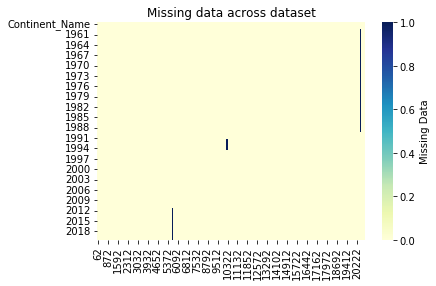

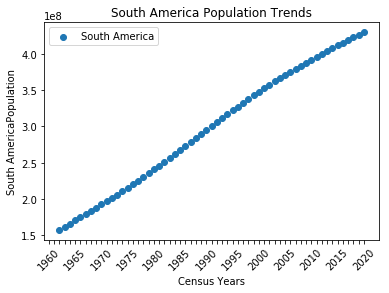

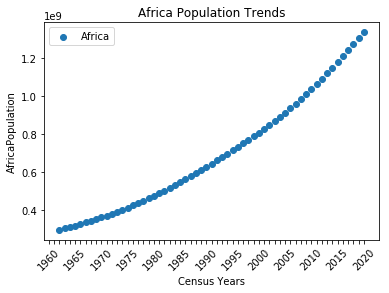

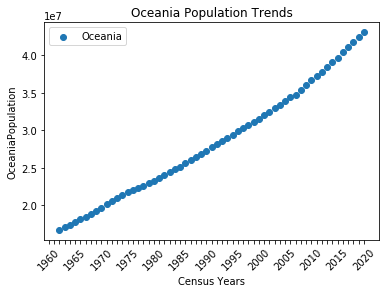

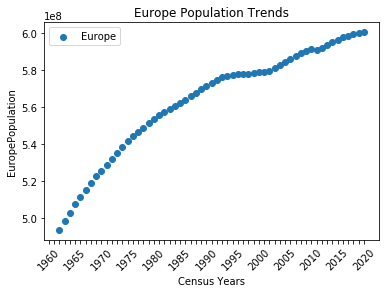

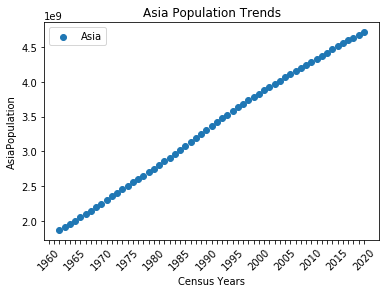

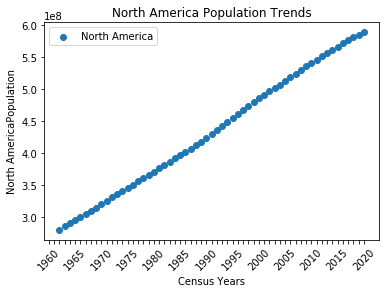

South America----------------------------------------------------------------------
Linear Regression Score:  0.997670276688299
Coefficent:  [4948459.65614456]
Intercept:  -9554645395.926144
Africa----------------------------------------------------------------------
Linear Regression Score:  0.9688488689750981
Coefficent:  [17639149.57676334]
Intercept:  -34420970451.015594
Oceania----------------------------------------------------------------------
Linear Regression Score:  0.990181317722634
Coefficent:  [433997.31331852]
Intercept:  -835657843.0657202
Europe----------------------------------------------------------------------
Linear Regression Score:  0.9247329730154505
Coefficent:  [1652587.23524867]
Intercept:  -2727690574.174811
Asia----------------------------------------------------------------------
Linear Regression Score:  0.9986243313833724
Coefficent:  [50770261.163902]
Intercept:  -97752848700.70558
North America----------------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  # This is added back by InteractiveShellApp.init_path()


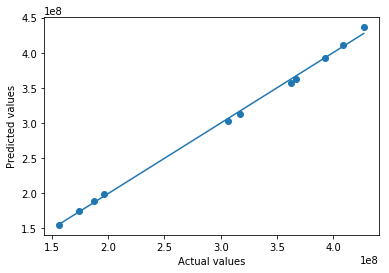

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  # This is added back by InteractiveShellApp.init_path()


Africa----------------------------------------------------------------------
R Squared:  0.9680941914940792
Mean Absolute Error:  45820472.86323606
Root Mean Squared Error:  2606927029751716.0


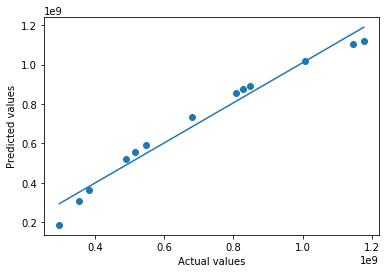

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  # This is added back by InteractiveShellApp.init_path()


Oceania----------------------------------------------------------------------
R Squared:  0.9910338814405667
Mean Absolute Error:  559575.9168065236
Root Mean Squared Error:  414002761176.4571


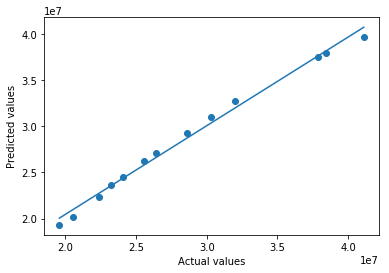

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  # This is added back by InteractiveShellApp.init_path()


Europe----------------------------------------------------------------------
R Squared:  0.9167774474745527
Mean Absolute Error:  5838186.470510165
Root Mean Squared Error:  43635826478354.88


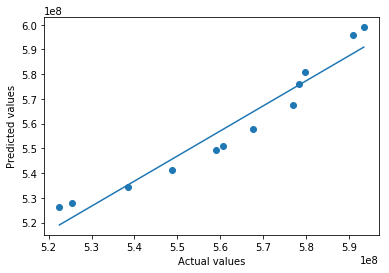

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  # This is added back by InteractiveShellApp.init_path()


Asia----------------------------------------------------------------------
R Squared:  0.998806209671833
Mean Absolute Error:  27991317.53433482
Root Mean Squared Error:  1036590692573619.1


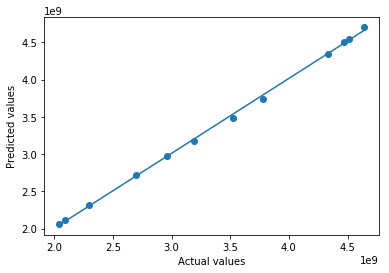

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  # This is added back by InteractiveShellApp.init_path()


North America----------------------------------------------------------------------
R Squared:  0.9994464689106052
Mean Absolute Error:  2141151.338145623
Root Mean Squared Error:  5500705993800.374


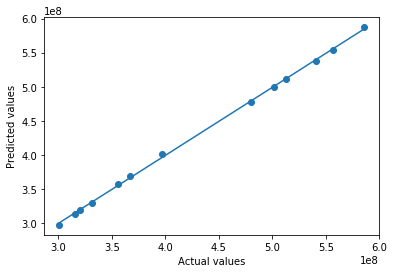

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  


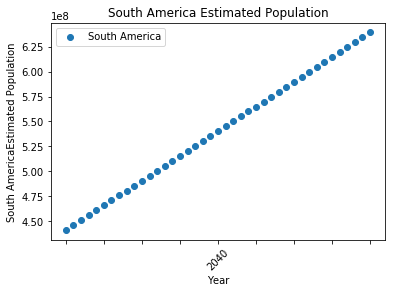

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  


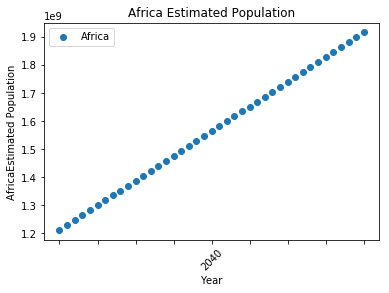

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  


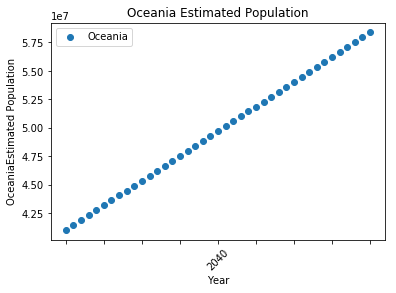

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  


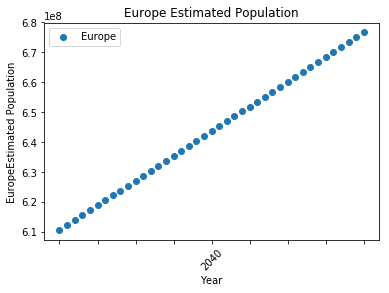

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  


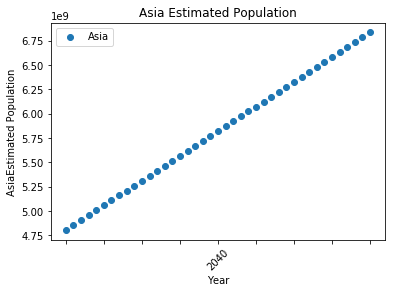

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  


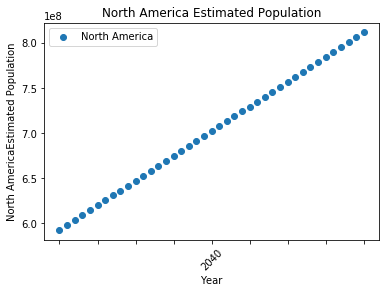

In [19]:
# main function
def main():
    pop_data = loadData()
   
    #checkForMissingData(pop_data)
    #get country and non coutry data
    country_data, non_country_data = getCountryNonCountryData(pop_data)
    
    # get total population of all countries
    pop_total = getTotalPopulation(country_data)
    
    # remove unwanted columns and format column names
    pop_total = formatTotalPopulation(pop_total)
    
    #check for missing data
    checkForMissingData(pop_total)
    
    #drop missing values
    pop_total = pop_total.dropna()
    
    #get total population of each continent
    continent_pop = continetWiseDataSplit(pop_total)
    
    #prepare data
    continent_train, continent_test =  splitData(continent_pop)
    
    # fit model for each continent
    continent_models  = fitLinearRegression(continent_train)
    
    #print scores, 
    linearRegressionScores(continent_models)
    
    #testmodel
    testModel(continent_test,continent_models)
    
    #estimate population from 2020 to 2060
    c_estimated_pop = predictPopulationEstimation(continent_models)
    
    #export csv
    exportEstimatedContinentPopulation(c_estimated_pop)

if __name__ == "__main__":
    main()

In [20]:
# conclusion